# MLP_from_scratch

**SGD MiniBactch OneHotEncoding**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

In [ ]:
class Neural_Network():
    def __init__(self, neurons, Activations):
        #two possible loss function are "CE" and "SE"  (cross entropy and sq. err)
        # arguments: an array "neurons" consist of number of neurons for each layer, 
        # an array "activations" consisting of activation functions used for the hidden layers and output layer
        self.inputSize = neurons[0] # Number of neurons in input layer
        self.outputSize = neurons[-1] # Number of neurons in output layer
        self.layers = len(neurons)
        self.weights = [] #weights for each layer
        self.biases = [] #biases in each layer 
        self.layer_activations = [] #activations in each layer
        #this change can be seen in the loop below
        for i in range(len(neurons)-1):    
            self.weights.append(np.random.rand(neurons[i+1],neurons[i])*0.001) #weight matrix between layer i and layer i+1
            self.biases.append(np.random.rand(neurons[i+1],1)*0.001)
            self.layer_activations.append(Activations[i]) #activations for each layer
            
    def sigmoid(self, z): # sigmoid activation function                
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoidPrime(self,z): # derivative of sigmoid activation function
        return self.sigmoid(z)*(1-self.sigmoid(z))

                          
    def tanh(self, z): # hyperbolic tan activation function                 
        return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))          
    
    def tanhPrime(self,x): # derivative of hyperbolic tan activation function
        return (1.0-(self.tanh(x))**2)                               
                          
    def linear(self, z): # Linear activation function                                    
        return z                                               
    
    def linearPrime(self,x): # derivative of linear activation function                                                      
        return np.ones(x.shape)                                       

    def ReLU(self,z): # ReLU activation function                  
        return np.maximum(0.001,z)               

    def ReLUPrime(self,z): # derivative of ReLU activation function
        return (z>0).astype(z.dtype)                                  
          
    def softmax(self, x):
        e = np.exp(x)
        return e/np.sum(e)
    
    def forward(self, a): # function of forward pass which will receive input and give the output of final layer
        
        layer_activations_a = [a] #store the input as the input layer activations
        layer_dot_prod_z = []
        for i, param in enumerate(zip(self.biases, self.weights)):
            b, w = param[0], param[1]
            if self.layer_activations[i].lower()=='sigmoid':
                z = np.dot(w, a)+b
                a = self.sigmoid(z)
            elif self.layer_activations[i].lower()=='relu':
                z = np.dot(w, a)+b
                a = self.ReLU(z)
            elif self.layer_activations[i].lower()=='tanh':   
                z = np.dot(w, a)+b
                a =self.tanh(z)
            elif self.layer_activations[i].lower()=='linear':
                z = np.dot(w, a)+b
                a = self.linear(z)
            layer_dot_prod_z.append(z)    
            layer_activations_a.append(a)
        return a, layer_dot_prod_z, layer_activations_a
                          
            
    
    def backward(self, x, y, zs, activations,l_f): # find the loss and return derivative of loss w.r.t every parameter
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        delta=(activations[-1] - y)
        # backward pass
        if(l_f=='SE' ):
            if self.layer_activations[-1].lower()=='sigmoid':
                delta = (activations[-1] - y)*self.sigmoidPrime(zs[-1])
            elif self.layer_activations[-1].lower()=='relu':
                delta = (activations[-1] - y)*ReLUPrime(zs[-1])
            elif self.layer_activations[-1].lower()=='tanh':   
                delta = (activations[-1] - y)*tanhPrime(zs[-1])
            elif self.layer_activations[-1].lower()=='linear':
                delta = (activations[-1] - y)*linearPrime(zs[-1])
        
        grad_b[-1] = np.sum(delta,axis=1,keepdims=True)/(delta.shape[1]) 
        grad_w[-1] = np.dot(delta,activations[-2].T)/(delta.shape[1])
                 
        for l in range(2, self.layers): # Here l is in backward sense i.e. last l th layer
            z = zs[-l]
            if self.layer_activations[-l].lower()=='sigmoid':
                prime = self.sigmoidPrime(z)
            elif self.layer_activations[-l].lower()=='relu':
                prime = self.ReLUPrime(z)
            elif self.layer_activations[-l].lower()=='tanh':   
                prime = self.tanhPrime(z)
            elif self.layer_activations[-l].lower()=='linear':
                prime = self.linearPrime(z)

            #Compute delta, gradients of b and w 
            delta = np.dot((self.weights[-l+1]).T,delta)*prime
            grad_w[-l] = np.dot(delta,activations[-l-1].T)/(delta.shape[1])
            grad_b[-l] = np.sum(delta,axis=1,keepdims=True)/(delta.shape[1]) 
                          
        return (grad_b, grad_w)                 

    def update_parameters(self, grads, learning_rate): # update the parameters using the gradients
        # update weights and biases using the gradients and the learning rate
        
        grad_b, grad_w = grads[0], grads[1]       
        
        self.weights = np.array(self.weights)
        self.biases = np.array(self.biases)
        grad_w = np.array(grad_w)
        grad_b = np.array(grad_b)

        #Implement the update rule for weights  and biases
        self.weights = self.weights - learning_rate*grad_w
        self.biases = self.biases - learning_rate*grad_b
        
    def loss(self, predicted, actual,l_f):
        #Implement the loss function
        predicted = self.softmax(predicted)
        if l_f=='CE':
            return -(1/(actual.shape[1]))*np.sum(actual*np.log(predicted))
        else:
            return (1/(actual.shape[1]))*np.sum(0.5*(predicted-actual)**2)
            
    def train(self, X, Y, minibatch=False,minibatchsize=20,lr=0.001,epochs=1000,l_f='CE',onehotencoded=True): # receive the full training data set
        loss_list = []
        if minibatch==False:
            for e in range(epochs): 
                losses = []
                for q in range(len(X)):
                    train_x = np.resize(X[q],(X[q].shape[0],1))
                    if not onehotencoded: 
                        train_y = np.resize(Y[q],(1,1))
                    else:
                        train_y = np.resize(Y[q],(Y[q].shape[0],1)) 
                    out, dot_prod_z, activations_a = self.forward(train_x)
                    loss = self.loss(out, train_y,l_f)
                    grads = self.backward(train_x, train_y, dot_prod_z, activations_a,l_f) # find the gradients using backward pass
                    self.update_parameters(grads, lr)
                    losses.append(loss)
                loss_list.append(np.mean(np.array(losses)))
                print(f'Epoch: {e} Loss: {np.mean(np.array(losses))}')
        else:
            X_mini,Y_mini = create_minibatches(X,Y,minibatchsize)
            for e in range(epochs):
                losses = []
                for X_b,Y_b in zip(X_mini,Y_mini):
                    train_x = X_b.T
                    if not onehotencoded:
                        train_y = Y_b.reshape(1,minibatchsize)
                    else:
                        train_y = Y_b.T
                    out, dot_prod_z, activations_a = self.forward(train_x)
                    loss = np.mean(np.array((self.loss(out, train_y,l_f))))
                    grads = self.backward(train_x, train_y, dot_prod_z, activations_a,l_f) # find the gradients using backward pass
                    self.update_parameters(grads, lr)
                    losses.append(loss)
                loss_list.append(np.mean(np.array(losses)))
                print(f'Epoch: {e} Loss: {np.mean(np.array(losses))}')
        return loss_list
        
    def predict(self, x):
        prediction,_,_ = self.forward(x)
        prediction = np.argmax(prediction,axis=0)
        return prediction

In [ ]:
# a method for creating one hot encoded labels 
def onehotencoding(Y):
    '''
        This is the function for applying one hot encoding
        for labels : [1,2,3]
        they would become : [[1,0,0],[0,0,1],[0,0,1]]
    '''
    all_labels = list(set(Y))
    y = np.zeros((len(Y),len(all_labels)))
    for i,e in enumerate(Y):
        y[i][e]=1
    return y

#a method to create minibatches 
def create_minibatches(X,Y,minibatchsize):
    numbatches = int(np.ceil(len(X)/minibatchsize))
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X_minibatches = []
    Y_minibatches = [] 
    for i in range(numbatches):
        idx_minibatch = idx[i*minibatchsize:min(len(idx),(i+1)*minibatchsize)]
        xn = np.take(X,idx_minibatch,axis=0) 
        yn = np.take(Y,idx_minibatch,axis=0)
        X_minibatches.append(xn)
        Y_minibatches.append(yn)
    return X_minibatches, Y_minibatches

def test_create_minibatches():
    X = []
    Y = []
    inputsize = 3
    minibatch = False
    onehotencoded = True
    n_batch = 20
    batch_size = 5
    for i in range(50):
        if(i % 2 == 0):
            X.append([np.random.randint(1,10) for i1 in range(inputsize)])
            Y.append(1)
        else:
            X.append([np.random.randint(-10,1) for i1 in range(inputsize)])
            Y.append(0)
    X = np.array(X)
    Y = np.array(Y)

    X_mb, Y_mb = create_minibatches(X,Y,6)
    print(X_mb, Y_mb)

# test_create_minibatches()

# Dataset()

In [ ]:
#this is the digits dataset 
digits = load_digits()

In [ ]:
X = digits['data']
Y = digits['target']
inputsize = 64
minibatch = False
onehotencoded = True
n_batch = 20
batch_size = 5
# for i in range(500):
#     if(i % 2 == 0):
#         X.append([random.randint(1,10) for i1 in range(inputsize)])
#         Y.append(1)
#     else:
#         X.append([random.randint(-10,1) for i1 in range(inputsize)])
#         Y.append(0)
X = np.array(X)
Y = np.array(Y)
if onehotencoded:
    Y = onehotencoding(Y)

train_X = X
train_Y = Y

In [ ]:
print(train_X.shape, train_Y.shape)

(1797, 64) (1797, 10)


# Network()

In [ ]:
#D_in is input dimension
#H1 is dimension of first hidden layer 
#H2 is dimension of second hidden layer
#D_out is output dimension.
D_in, H1, H2,D_out = inputsize, 256, 128 ,10                              #You can add more layers if you wish to 

neurons = [D_in, H1, H2, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['sigmoid','sigmoid', 'sigmoid'] #activations in each layer (Note: the input layer does not have any activation)
my_neuralnet_ce = Neural_Network(neurons, activation_functions)

# Training the network

1. loss_function = 'Cross entropy' 

learning_rate = 0.01, 
epochs = 200

In [ ]:
loss_ce = my_neuralnet_ce.train(train_X,train_Y,minibatch=False,lr=0.01,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 2.3105664263105523
Epoch: 1 Loss: 2.307718479471038
Epoch: 2 Loss: 2.306349887213897
Epoch: 3 Loss: 2.3056748026092357
Epoch: 4 Loss: 2.3052608967271935
Epoch: 5 Loss: 2.304970389062264
Epoch: 6 Loss: 2.3047478562904726
Epoch: 7 Loss: 2.3045656901325544
Epoch: 8 Loss: 2.3044064787661713
Epoch: 9 Loss: 2.3042548652336263
Epoch: 10 Loss: 2.304089881337187
Epoch: 11 Loss: 2.3038680909738
Epoch: 12 Loss: 2.3034711131363537
Epoch: 13 Loss: 2.302544715943943
Epoch: 14 Loss: 2.2997835389902357
Epoch: 15 Loss: 2.28433147374366
Epoch: 16 Loss: 2.24361983278614
Epoch: 17 Loss: 2.2092597157640044
Epoch: 18 Loss: 2.197616196996547
Epoch: 19 Loss: 2.1705355644439344
Epoch: 20 Loss: 2.132932679885627
Epoch: 21 Loss: 2.0963252693758134
Epoch: 22 Loss: 2.046533097656402
Epoch: 23 Loss: 1.9726885738521909
Epoch: 24 Loss: 1.8901872893969702
Epoch: 25 Loss: 1.8162395360791326
Epoch: 26 Loss: 1.7428997899359893
Epoch: 27 Loss: 1.692749700078024
Epoch: 28 Loss: 1.6548319873449107
Epoch: 29 L

# Cross Entropy Loss 3.(b)

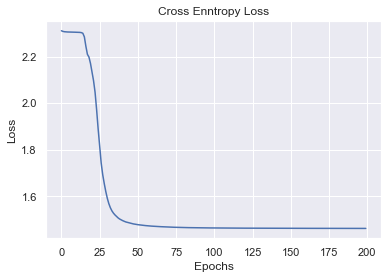

In [ ]:
sns.set()
plt.plot(loss_ce)
plt.title("Cross Enntropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("cross_entropy.png")
plt.show()

2. loss_function = 'Squared Error'
<br>
learning_rate = 0.01, 
epochs = 200

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)

In [ ]:
loss_se = my_neuralnet_se.train(train_X,train_Y,minibatch=False,lr=0.01,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.4501717588980463
Epoch: 1 Loss: 0.45013345858566883
Epoch: 2 Loss: 0.4501326586147261
Epoch: 3 Loss: 0.4501318908905271
Epoch: 4 Loss: 0.4501311365001133
Epoch: 5 Loss: 0.45013039500155144
Epoch: 6 Loss: 0.45012966598738363
Epoch: 7 Loss: 0.4501289490576496
Epoch: 8 Loss: 0.4501282438200826
Epoch: 9 Loss: 0.4501275498903104
Epoch: 10 Loss: 0.4501268668920046
Epoch: 11 Loss: 0.4501261944569855
Epoch: 12 Loss: 0.4501255322252872
Epoch: 13 Loss: 0.45012487984518756
Epoch: 14 Loss: 0.4501242369732082
Epoch: 15 Loss: 0.45012360327408774
Epoch: 16 Loss: 0.45012297842073345
Epoch: 17 Loss: 0.4501223620941538
Epoch: 18 Loss: 0.4501217539833749
Epoch: 19 Loss: 0.45012115378534473
Epoch: 20 Loss: 0.45012056120482663
Epoch: 21 Loss: 0.45011997595428516
Epoch: 22 Loss: 0.45011939775376597
Epoch: 23 Loss: 0.45011882633077144
Epoch: 24 Loss: 0.4501182614201342
Epoch: 25 Loss: 0.45011770276388946
Epoch: 26 Loss: 0.450117150111148
Epoch: 27 Loss: 0.4501166032179696
Epoch: 28 Loss: 0.4

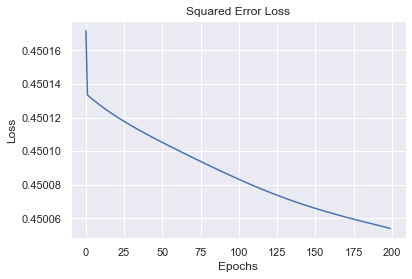

In [ ]:
sns.set()
plt.plot(loss_se)
plt.title("Squared Error Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("squared_error.png")
plt.show()

# Squared Error best learning_rate

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_1 = my_neuralnet_se.train(train_X,train_Y,minibatch=False,lr=0.1,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.45065622398312283
Epoch: 1 Loss: 0.4505052819011906
Epoch: 2 Loss: 0.45039110956894385
Epoch: 3 Loss: 0.45032106528095905
Epoch: 4 Loss: 0.4502771932678737
Epoch: 5 Loss: 0.4502468123243712
Epoch: 6 Loss: 0.4502240494010698
Epoch: 7 Loss: 0.450205986206229
Epoch: 8 Loss: 0.4501910284532236
Epoch: 9 Loss: 0.450178210976631
Epoch: 10 Loss: 0.45016686578410997
Epoch: 11 Loss: 0.450156446835737
Epoch: 12 Loss: 0.45014641370789515
Epoch: 13 Loss: 0.45013610448779173
Epoch: 14 Loss: 0.45012451708231127
Epoch: 15 Loss: 0.450109845617616
Epoch: 16 Loss: 0.4500884578432492
Epoch: 17 Loss: 0.45005308463540467
Epoch: 18 Loss: 0.4499923903085177
Epoch: 19 Loss: 0.4498956452271861
Epoch: 20 Loss: 0.44975034389838814
Epoch: 21 Loss: 0.4495276413566185
Epoch: 22 Loss: 0.44916370156175206
Epoch: 23 Loss: 0.4485000288105436
Epoch: 24 Loss: 0.4460752905683142
Epoch: 25 Loss: 0.4394530630356069
Epoch: 26 Loss: 0.43631472860084836
Epoch: 27 Loss: 0.4322654816864612
Epoch: 28 Loss: 0.42199

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_2 = my_neuralnet_se.train(train_X,train_Y,minibatch=False,lr=0.01,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.45017171224580543
Epoch: 1 Loss: 0.45013343331947153
Epoch: 2 Loss: 0.4501326346697388
Epoch: 3 Loss: 0.45013186829477425
Epoch: 4 Loss: 0.45013111523838306
Epoch: 5 Loss: 0.4501303750586712
Epoch: 6 Loss: 0.45012964734836003
Epoch: 7 Loss: 0.45012893170770285
Epoch: 8 Loss: 0.4501282277446762
Epoch: 9 Loss: 0.45012753507517606
Epoch: 10 Loss: 0.4501268533231631
Epoch: 11 Loss: 0.45012618212076344
Epoch: 12 Loss: 0.45012552110832993
Epoch: 13 Loss: 0.4501248699344688
Epoch: 14 Loss: 0.45012422825603654
Epoch: 15 Loss: 0.4501235957381101
Epoch: 16 Loss: 0.45012297205393664
Epoch: 17 Loss: 0.4501223568848621
Epoch: 18 Loss: 0.450121749920247
Epoch: 19 Loss: 0.45012115085736787
Epoch: 20 Loss: 0.4501205594013086
Epoch: 21 Loss: 0.4501199752648453
Epoch: 22 Loss: 0.45011939816832425
Epoch: 23 Loss: 0.45011882783953583
Epoch: 24 Loss: 0.4501182640135871
Epoch: 25 Loss: 0.4501177064327731
Epoch: 26 Loss: 0.45011715484644793
Epoch: 27 Loss: 0.45011660901089834
Epoch: 28 Loss:

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_3 = my_neuralnet_se.train(train_X,train_Y,minibatch=False,lr=0.001,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.45004845465133664
Epoch: 1 Loss: 0.4500210621281551
Epoch: 2 Loss: 0.4500162674150272
Epoch: 3 Loss: 0.45001451480671173
Epoch: 4 Loss: 0.4500137178234805
Epoch: 5 Loss: 0.4500133208359745
Epoch: 6 Loss: 0.4500131140586863
Epoch: 7 Loss: 0.45001300364580266
Epoch: 8 Loss: 0.4500129437025604
Epoch: 9 Loss: 0.45001291067974986
Epoch: 10 Loss: 0.45001289216970525
Epoch: 11 Loss: 0.45001288153550434
Epoch: 12 Loss: 0.4500128751946198
Epoch: 13 Loss: 0.4500128712018909
Epoch: 14 Loss: 0.45001286849685174
Epoch: 15 Loss: 0.45001286649956845
Epoch: 16 Loss: 0.4500128648921026
Epoch: 17 Loss: 0.45001286349978087
Epoch: 18 Loss: 0.4500128622264602
Epoch: 19 Loss: 0.4500128610191334
Epoch: 20 Loss: 0.4500128598485311
Epoch: 21 Loss: 0.45001285869846913
Epoch: 22 Loss: 0.4500128575599869
Epoch: 23 Loss: 0.45001285642811734
Epoch: 24 Loss: 0.4500128553001039
Epoch: 25 Loss: 0.450012854174415
Epoch: 26 Loss: 0.45001285305019945
Epoch: 27 Loss: 0.45001285192698287
Epoch: 28 Loss: 0.

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_4 = my_neuralnet_se.train(train_X,train_Y,minibatch=False,lr=0.00001,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.4500007391787828
Epoch: 1 Loss: 0.4500006674723313
Epoch: 2 Loss: 0.45000059704556844
Epoch: 3 Loss: 0.4500005285477949
Epoch: 4 Loss: 0.4500004624540704
Epoch: 5 Loss: 0.45000039908870343
Epoch: 6 Loss: 0.45000033865043954
Epoch: 7 Loss: 0.45000028123694386
Epoch: 8 Loss: 0.450000226867112
Epoch: 9 Loss: 0.4500001755004733
Epoch: 10 Loss: 0.45000012705346143
Epoch: 11 Loss: 0.4500000814126552
Epoch: 12 Loss: 0.4500000384452762
Epoch: 13 Loss: 0.4499999980073154
Epoch: 14 Loss: 0.44999995994967584
Epoch: 15 Loss: 0.4499999241227016
Epoch: 16 Loss: 0.44999989037942306
Epoch: 17 Loss: 0.4499998585777976
Epoch: 18 Loss: 0.4499998285821819
Epoch: 19 Loss: 0.4499998002642227
Epoch: 20 Loss: 0.4499997735033179
Epoch: 21 Loss: 0.44999974818676497
Epoch: 22 Loss: 0.4499997242096877
Epoch: 23 Loss: 0.4499997014748104
Epoch: 24 Loss: 0.44999967989213197
Epoch: 25 Loss: 0.4499996593785378
Epoch: 26 Loss: 0.44999963985737834
Epoch: 27 Loss: 0.44999962125803467
Epoch: 28 Loss: 0.44

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_5 = my_neuralnet_se.train(train_X,train_Y,minibatch=False,lr=0.000001,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.45000013105623166
Epoch: 1 Loss: 0.4500001225886197
Epoch: 2 Loss: 0.4500001141503492
Epoch: 3 Loss: 0.4500001057423574
Epoch: 4 Loss: 0.45000009736555374
Epoch: 5 Loss: 0.4500000890208203
Epoch: 6 Loss: 0.4500000807090112
Epoch: 7 Loss: 0.4500000724309539
Epoch: 8 Loss: 0.4500000641874484
Epoch: 9 Loss: 0.4500000559792678
Epoch: 10 Loss: 0.4500000478071588
Epoch: 11 Loss: 0.45000003967184166
Epoch: 12 Loss: 0.45000003157401064
Epoch: 13 Loss: 0.45000002351433405
Epoch: 14 Loss: 0.45000001549345475
Epoch: 15 Loss: 0.45000000751199054
Epoch: 16 Loss: 0.4499999995705342
Epoch: 17 Loss: 0.44999999166965376
Epoch: 18 Loss: 0.4499999838098934
Epoch: 19 Loss: 0.4499999759917731
Epoch: 20 Loss: 0.44999996821578947
Epoch: 21 Loss: 0.4499999604824158
Epoch: 22 Loss: 0.44999995279210253
Epoch: 23 Loss: 0.4499999451452779
Epoch: 24 Loss: 0.4499999375423476
Epoch: 25 Loss: 0.44999992998369615
Epoch: 26 Loss: 0.4499999224696863
Epoch: 27 Loss: 0.44999991500066006
Epoch: 28 Loss: 0.

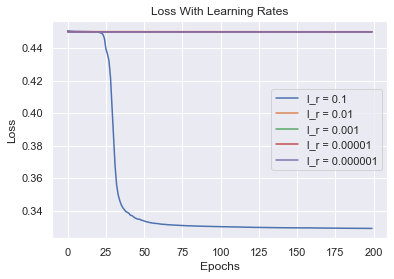

In [ ]:
plt.plot(loss_se_1,label="l_r = 0.1")
plt.plot(loss_se_2,label="l_r = 0.01")
plt.plot(loss_se_3,label="l_r = 0.001")
plt.plot(loss_se_4,label="l_r = 0.00001")
plt.plot(loss_se_5,label="l_r = 0.000001")
plt.title("Loss With Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**Clearly l_r = 0.1 is a winner rest don't even seen to learn much, the might be low value of gradients**

# learning_rate_cross_entropy

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_1 = my_neuralnet_ce.train(train_X,train_Y,minibatch=False,lr=0.1,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 2.31026899284832
Epoch: 1 Loss: 2.307248086209967
Epoch: 2 Loss: 2.3064875565299725
Epoch: 3 Loss: 2.262166260337182
Epoch: 4 Loss: 2.2182856064370573
Epoch: 5 Loss: 2.138766123153335
Epoch: 6 Loss: 1.9573321184065604
Epoch: 7 Loss: 1.8012165154998567
Epoch: 8 Loss: 1.7824454209401506
Epoch: 9 Loss: 1.8688984202412582
Epoch: 10 Loss: 1.8186446971572126
Epoch: 11 Loss: 1.8267621285819922
Epoch: 12 Loss: 1.8205531696449508
Epoch: 13 Loss: 1.7895401708298175
Epoch: 14 Loss: 1.8145276213194919
Epoch: 15 Loss: 1.8516029601650856
Epoch: 16 Loss: 1.8232439782103822
Epoch: 17 Loss: 1.83110204924744
Epoch: 18 Loss: 1.8049288914653947
Epoch: 19 Loss: 1.8149616483551068
Epoch: 20 Loss: 1.8357020890519333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Epoch: 21 Loss: 1.9174943153030308
Epoch: 22 Loss: 1.8640012896436084
Epoch: 23 Loss: 1.8578670314796326
Epoch: 24 Loss: 1.8526523971049278
Epoch: 25 Loss: 1.8570783010013803
Epoch: 26 Loss: 1.8423389197262885
Epoch: 27 Loss: 1.8121279763323
Epoch: 28 Loss: 1.8023329984544951
Epoch: 29 Loss: 1.8034180486031754
Epoch: 30 Loss: 1.8157499157443675
Epoch: 31 Loss: 1.8109622361414262
Epoch: 32 Loss: 1.7872028360517072
Epoch: 33 Loss: 1.7980005487119677
Epoch: 34 Loss: 1.8809104013168902
Epoch: 35 Loss: 1.869525644513668
Epoch: 36 Loss: 1.8840546619479563
Epoch: 37 Loss: 2.0322059877994483
Epoch: 38 Loss: 1.9436199094714668
Epoch: 39 Loss: 1.9623294768121906
Epoch: 40 Loss: 1.9672154549061787
Epoch: 41 Loss: 1.9940892055934378
Epoch: 42 Loss: 1.9887397334252124
Epoch: 43 Loss: 2.061746740318192
Epoch: 44 Loss: 2.063828947513753
Epoch: 45 Loss: 2.048940463329368
Epoch: 46 Loss: 2.102592214734305
Epoch: 47 Loss: 2.0266732193209074
Epoch: 48 Loss: 2.0761152460405716
Epoch: 49 Loss: 2.1191969301

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_2 = my_neuralnet_ce.train(train_X,train_Y,minibatch=False,lr=0.01,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 2.3105671166764155
Epoch: 1 Loss: 2.3077197970515395
Epoch: 2 Loss: 2.306350577905741
Epoch: 3 Loss: 2.30567527889556
Epoch: 4 Loss: 2.3052612809912683
Epoch: 5 Loss: 2.3049707153699903
Epoch: 6 Loss: 2.304748124746379
Epoch: 7 Loss: 2.3045658778154654
Epoch: 8 Loss: 2.3044065308406996
Epoch: 9 Loss: 2.30425465735316
Epoch: 10 Loss: 2.304089104794543
Epoch: 11 Loss: 2.3038658744250298
Epoch: 12 Loss: 2.3034647394481254
Epoch: 13 Loss: 2.3025250850536474
Epoch: 14 Loss: 2.299691493383
Epoch: 15 Loss: 2.283667951574293
Epoch: 16 Loss: 2.2412141922242252
Epoch: 17 Loss: 2.2083620564114543
Epoch: 18 Loss: 2.1973976707078906
Epoch: 19 Loss: 2.170080821678737
Epoch: 20 Loss: 2.1305438392590523
Epoch: 21 Loss: 2.090887781041003
Epoch: 22 Loss: 2.040807960196997
Epoch: 23 Loss: 1.9718201748582582
Epoch: 24 Loss: 1.8976107882720619
Epoch: 25 Loss: 1.8339438528893883
Epoch: 26 Loss: 1.7543327763566965
Epoch: 27 Loss: 1.6989946955691464
Epoch: 28 Loss: 1.660129531134704
Epoch: 29 L

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_3 = my_neuralnet_ce.train(train_X,train_Y,minibatch=False,lr=0.001,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 2.304355178544827
Epoch: 1 Loss: 2.304113047235742
Epoch: 2 Loss: 2.304101109838473
Epoch: 3 Loss: 2.304089537195518
Epoch: 4 Loss: 2.304078230565184
Epoch: 5 Loss: 2.3040671788948677
Epoch: 6 Loss: 2.3040563714694606
Epoch: 7 Loss: 2.304045797867182
Epoch: 8 Loss: 2.3040354479643894
Epoch: 9 Loss: 2.304025311937995
Epoch: 10 Loss: 2.304015380265836
Epoch: 11 Loss: 2.3040056437253287
Epoch: 12 Loss: 2.303996093390728
Epoch: 13 Loss: 2.3039867206292435
Epoch: 14 Loss: 2.3039775170962766
Epoch: 15 Loss: 2.303968474729962
Epoch: 16 Loss: 2.3039595857452198
Epoch: 17 Loss: 2.30395084262747
Epoch: 18 Loss: 2.3039422381261363
Epoch: 19 Loss: 2.3039337652480705
Epoch: 20 Loss: 2.3039254172509884
Epoch: 21 Loss: 2.303917187637002
Epoch: 22 Loss: 2.303909070146316
Epoch: 23 Loss: 2.3039010587511433
Epoch: 24 Loss: 2.3038931476498923
Epoch: 25 Loss: 2.303885331261647
Epoch: 26 Loss: 2.3038776042209825
Epoch: 27 Loss: 2.303869961373116
Epoch: 28 Loss: 2.3038623977694255
Epoch: 29 L

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_4 = my_neuralnet_ce.train(train_X,train_Y,minibatch=False,lr=0.00001,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 2.30262385490462
Epoch: 1 Loss: 2.3026202782214162
Epoch: 2 Loss: 2.3026168055174536
Epoch: 3 Loss: 2.3026136113965334
Epoch: 4 Loss: 2.302610749821869
Epoch: 5 Loss: 2.302608217085534
Epoch: 6 Loss: 2.30260598527836
Epoch: 7 Loss: 2.302604018817761
Epoch: 8 Loss: 2.3026022820634853
Epoch: 9 Loss: 2.3026007424728117
Epoch: 10 Loss: 2.3025993716129096
Epoch: 11 Loss: 2.3025981451972855
Epoch: 12 Loss: 2.302597042719231
Epoch: 13 Loss: 2.302596046955458
Epoch: 14 Loss: 2.302595143464004
Epoch: 15 Loss: 2.3025943201275942
Epoch: 16 Loss: 2.3025935667589223
Epoch: 17 Loss: 2.3025928747684876
Epoch: 18 Loss: 2.302592236889129
Epoch: 19 Loss: 2.302591646949344
Epoch: 20 Loss: 2.302591099687391
Epoch: 21 Loss: 2.30259059059899
Epoch: 22 Loss: 2.302590115812451
Epoch: 23 Loss: 2.3025896719860928
Epoch: 24 Loss: 2.3025892562237784
Epoch: 25 Loss: 2.3025888660051548
Epoch: 26 Loss: 2.3025884991278542
Epoch: 27 Loss: 2.3025881536594563
Epoch: 28 Loss: 2.3025878278974288
Epoch: 29 L

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_5 = my_neuralnet_ce.train(train_X,train_Y,minibatch=False,lr=0.000001,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 2.3025863508047317
Epoch: 1 Loss: 2.3025860675763523
Epoch: 2 Loss: 2.3025857890259296
Epoch: 3 Loss: 2.3025855152861547
Epoch: 4 Loss: 2.3025852464659478
Epoch: 5 Loss: 2.3025849826522093
Epoch: 6 Loss: 2.3025847239115165
Epoch: 7 Loss: 2.3025844702917495
Epoch: 8 Loss: 2.3025842218236554
Epoch: 9 Loss: 2.3025839785223345
Epoch: 10 Loss: 2.3025837403886524
Epoch: 11 Loss: 2.302583507410575
Epoch: 12 Loss: 2.3025832795644314
Epoch: 13 Loss: 2.3025830568160908
Epoch: 14 Loss: 2.3025828391220777
Epoch: 15 Loss: 2.3025826264305995
Epoch: 16 Loss: 2.302582418682516
Epoch: 17 Loss: 2.302582215812228
Epoch: 18 Loss: 2.302582017748508
Epoch: 19 Loss: 2.3025818244152636
Epoch: 20 Loss: 2.3025816357322446
Epoch: 21 Loss: 2.302581451615686
Epoch: 22 Loss: 2.3025812719789025
Epoch: 23 Loss: 2.3025810967328293
Epoch: 24 Loss: 2.302580925786518
Epoch: 25 Loss: 2.3025807590475806
Epoch: 26 Loss: 2.3025805964226014
Epoch: 27 Loss: 2.3025804378175
Epoch: 28 Loss: 2.302580283137866
Epoch

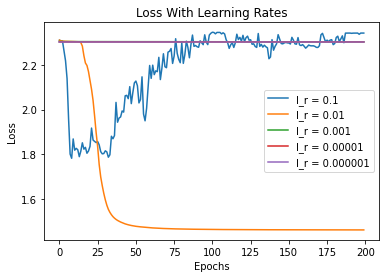

In [ ]:
plt.plot(loss_ce_1,label="l_r = 0.1")
plt.plot(loss_ce_2,label="l_r = 0.01")
plt.plot(loss_ce_3,label="l_r = 0.001")
plt.plot(loss_ce_4,label="l_r = 0.00001")
plt.plot(loss_ce_5,label="l_r = 0.000001")
plt.title("Loss With Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")  
plt.legend()
plt.savefig('CE_learning_rates.png')

learning_rate = 0.01 performs best <br> for l_r = 0.1 there was some runtime exception may be due to high learning rate

# Minibatch

In [ ]:
def create_minibatches(X,Y,minibatchsize):
    numbatches = int(np.ceil(len(X)/minibatchsize))
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X_minibatches = []
    Y_minibatches = [] 
    for i in range(numbatches):
        idx_minibatch = idx[i*minibatchsize:min(len(idx),(i+1)*minibatchsize)]
        xn = np.take(X,idx_minibatch,axis=0) 
        yn = np.take(Y,idx_minibatch,axis=0)
        X_minibatches.append(xn)
        Y_minibatches.append(yn)
    return X_minibatches, Y_minibatches

**For CE**

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_mini_1 = my_neuralnet_ce.train(train_X,train_Y,minibatch=True,minibatchsize=50,lr=1,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 6.213435018366746
Epoch: 1 Loss: 6.213311501219537
Epoch: 2 Loss: 6.213146735909409
Epoch: 3 Loss: 6.212797040685497
Epoch: 4 Loss: 6.211843293084667
Epoch: 5 Loss: 6.208217595045552
Epoch: 6 Loss: 6.185279317756814
Epoch: 7 Loss: 6.182341023495877
Epoch: 8 Loss: 6.13767589559499
Epoch: 9 Loss: 6.118640461220179
Epoch: 10 Loss: 6.096895835391056
Epoch: 11 Loss: 6.08250820604609
Epoch: 12 Loss: 6.053923270266089
Epoch: 13 Loss: 6.0028310430591585
Epoch: 14 Loss: 5.959566105391832
Epoch: 15 Loss: 5.925599251370738
Epoch: 16 Loss: 5.907479265193297
Epoch: 17 Loss: 5.8423645866910725
Epoch: 18 Loss: 5.809150982367864
Epoch: 19 Loss: 5.75788288002908
Epoch: 20 Loss: 5.712699824684349
Epoch: 21 Loss: 5.6710455443739
Epoch: 22 Loss: 5.721970216149626
Epoch: 23 Loss: 5.755563572291771
Epoch: 24 Loss: 5.660119423121208
Epoch: 25 Loss: 5.622219128600665
Epoch: 26 Loss: 5.618287793763648
Epoch: 27 Loss: 5.540426661680713
Epoch: 28 Loss: 5.519953387740503
Epoch: 29 Loss: 5.507070872

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_mini_2 = my_neuralnet_ce.train(train_X,train_Y,minibatch=True,minibatchsize=100,lr=1,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 6.906398167398303
Epoch: 1 Loss: 6.906326956202388
Epoch: 2 Loss: 6.9062321407176555
Epoch: 3 Loss: 6.90598841521668
Epoch: 4 Loss: 6.905522282546346
Epoch: 5 Loss: 6.9044979145315555
Epoch: 6 Loss: 6.902152023817695
Epoch: 7 Loss: 6.896491812460052
Epoch: 8 Loss: 6.884554090625738
Epoch: 9 Loss: 6.85785355772458
Epoch: 10 Loss: 6.828791117348854
Epoch: 11 Loss: 6.80886750919832
Epoch: 12 Loss: 6.798052554199864
Epoch: 13 Loss: 6.788548237004772
Epoch: 14 Loss: 6.772363434025967
Epoch: 15 Loss: 6.759335692112969
Epoch: 16 Loss: 6.750872743118007
Epoch: 17 Loss: 6.741753334151664
Epoch: 18 Loss: 6.727518867800705
Epoch: 19 Loss: 6.710760374702456
Epoch: 20 Loss: 6.6862343516269025
Epoch: 21 Loss: 6.669130984577597
Epoch: 22 Loss: 6.653351512077547
Epoch: 23 Loss: 6.615128413994463
Epoch: 24 Loss: 6.584362934384168
Epoch: 25 Loss: 6.568549282505318
Epoch: 26 Loss: 6.495655437444558
Epoch: 27 Loss: 6.45917040038867
Epoch: 28 Loss: 6.38694190396029
Epoch: 29 Loss: 6.32828488

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_mini_3 = my_neuralnet_ce.train(train_X,train_Y,minibatch=True,minibatchsize=100,lr=1,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 6.9066741516504875
Epoch: 1 Loss: 6.90619285055138
Epoch: 2 Loss: 6.905753103198429
Epoch: 3 Loss: 6.904706370753903
Epoch: 4 Loss: 6.903036870827047
Epoch: 5 Loss: 6.8997542293619665
Epoch: 6 Loss: 6.893668557929952
Epoch: 7 Loss: 6.884153815347052
Epoch: 8 Loss: 6.866028082689937
Epoch: 9 Loss: 6.839248352822576
Epoch: 10 Loss: 6.823733040403313
Epoch: 11 Loss: 6.817186254562788
Epoch: 12 Loss: 6.804759473187207
Epoch: 13 Loss: 6.8010284094098505
Epoch: 14 Loss: 6.798358455381495
Epoch: 15 Loss: 6.792680394578976
Epoch: 16 Loss: 6.789664481810495
Epoch: 17 Loss: 6.759811590302501
Epoch: 18 Loss: 6.744725747994386
Epoch: 19 Loss: 6.7244271434669525
Epoch: 20 Loss: 6.69220756410278
Epoch: 21 Loss: 6.667408510538716
Epoch: 22 Loss: 6.611608912934419
Epoch: 23 Loss: 6.562003013852023
Epoch: 24 Loss: 6.511847357215698
Epoch: 25 Loss: 6.48641641636842
Epoch: 26 Loss: 6.40943897683082
Epoch: 27 Loss: 6.341192726213214
Epoch: 28 Loss: 6.297327604181327
Epoch: 29 Loss: 6.252388

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_mini_4 = my_neuralnet_ce.train(train_X,train_Y,minibatch=True,minibatchsize=200,lr=1,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 7.5995067267228045
Epoch: 1 Loss: 7.599429256274353
Epoch: 2 Loss: 7.599391980380158
Epoch: 3 Loss: 7.599378422979894
Epoch: 4 Loss: 7.59937285649374
Epoch: 5 Loss: 7.599370452837263
Epoch: 6 Loss: 7.599369394064851
Epoch: 7 Loss: 7.599368924147159
Epoch: 8 Loss: 7.599368714998549
Epoch: 9 Loss: 7.599368621781683
Epoch: 10 Loss: 7.599368580150304
Epoch: 11 Loss: 7.599368561464676
Epoch: 12 Loss: 7.599368552977255
Epoch: 13 Loss: 7.599368549017997
Epoch: 14 Loss: 7.599368547067257
Epoch: 15 Loss: 7.599368546006476
Epoch: 16 Loss: 7.599368545339571
Epoch: 17 Loss: 7.599368544846734
Epoch: 18 Loss: 7.599368544430657
Epoch: 19 Loss: 7.599368544048294
Epoch: 20 Loss: 7.599368543680622
Epoch: 21 Loss: 7.599368543319236
Epoch: 22 Loss: 7.599368542960423
Epoch: 23 Loss: 7.599368542602548
Epoch: 24 Loss: 7.599368542244887
Epoch: 25 Loss: 7.599368541887121
Epoch: 26 Loss: 7.599368541529109
Epoch: 27 Loss: 7.5993685411707865
Epoch: 28 Loss: 7.599368540812127
Epoch: 29 Loss: 7.59936

In [ ]:
my_neuralnet_ce = Neural_Network(neurons, activation_functions)
loss_ce_mini_5 = my_neuralnet_ce.train(train_X,train_Y,minibatch=True,minibatchsize=500,lr=1,epochs=200,l_f='CE',onehotencoded=True)

Epoch: 0 Loss: 8.387238636188044
Epoch: 1 Loss: 8.387064589960222
Epoch: 2 Loss: 8.387036483255908
Epoch: 3 Loss: 8.387021150644975
Epoch: 4 Loss: 8.387012475939825
Epoch: 5 Loss: 8.387007076538204
Epoch: 6 Loss: 8.387003490714477
Epoch: 7 Loss: 8.387001012842479
Epoch: 8 Loss: 8.386999258082069
Epoch: 9 Loss: 8.386997995767391
Epoch: 10 Loss: 8.386997078031099
Epoch: 11 Loss: 8.386996405377381
Epoch: 12 Loss: 8.3869959086155
Epoch: 13 Loss: 8.386995538632014
Epoch: 14 Loss: 8.386995260156855
Epoch: 15 Loss: 8.386995047713668
Epoch: 16 Loss: 8.38699488285984
Epoch: 17 Loss: 8.38699475224398
Epoch: 18 Loss: 8.38699464621184
Epoch: 19 Loss: 8.386994557795125
Epoch: 20 Loss: 8.386994481974645
Epoch: 21 Loss: 8.386994415142665
Epoch: 22 Loss: 8.386994354711053
Epoch: 23 Loss: 8.38699429882625
Epoch: 24 Loss: 8.386994246162516
Epoch: 25 Loss: 8.386994195772381
Epoch: 26 Loss: 8.38699414697882
Epoch: 27 Loss: 8.386994099297704
Epoch: 28 Loss: 8.386994052382185
Epoch: 29 Loss: 8.3869940059829

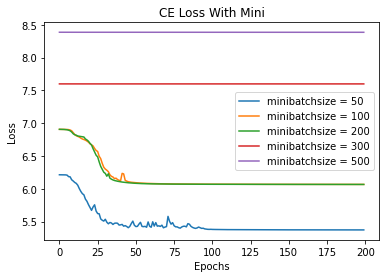

In [ ]:
plt.plot(loss_ce_mini_1,label="minibatchsize = 50")
plt.plot(loss_ce_mini_2,label="minibatchsize = 100")
plt.plot(loss_ce_mini_3,label="minibatchsize = 200")
plt.plot(loss_ce_mini_4,label="minibatchsize = 300")
plt.plot(loss_ce_mini_5,label="minibatchsize = 500")
plt.title("CE Loss With Mini")
plt.xlabel("Epochs")
plt.ylabel("Loss")  
plt.legend(loc='right')
plt.savefig('minibatch_CE.png')

**As we increase the batch size algorihtms learns less for a given no. of epochs althogh computational wise it becomes fast(sue to vectorized implementation).**

**For SE**

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_mini_1 = my_neuralnet_se.train(train_X,train_Y,minibatch=True,minibatchsize=50,lr=1,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.49801685379850164
Epoch: 1 Loss: 0.49801743059161
Epoch: 2 Loss: 0.4980174425815114
Epoch: 3 Loss: 0.49801743956135447
Epoch: 4 Loss: 0.4980174364768367
Epoch: 5 Loss: 0.49801743333696735
Epoch: 6 Loss: 0.49801743014808303
Epoch: 7 Loss: 0.4980174269162587
Epoch: 8 Loss: 0.49801742364719304
Epoch: 9 Loss: 0.498017420346121
Epoch: 10 Loss: 0.4980174170177583
Epoch: 11 Loss: 0.4980174136662683
Epoch: 12 Loss: 0.49801741029525093
Epoch: 13 Loss: 0.4980174069077481
Epoch: 14 Loss: 0.4980174035062561
Epoch: 15 Loss: 0.4980174000927454
Epoch: 16 Loss: 0.49801739666868056
Epoch: 17 Loss: 0.49801739323503774
Epoch: 18 Loss: 0.49801738979231935
Epoch: 19 Loss: 0.49801738634056403
Epoch: 20 Loss: 0.4980173828793491
Epoch: 21 Loss: 0.49801737940778895
Epoch: 22 Loss: 0.4980173759245265
Epoch: 23 Loss: 0.49801737242771843
Epoch: 24 Loss: 0.4980173689150152
Epoch: 25 Loss: 0.4980173653835345
Epoch: 26 Loss: 0.49801736182982975
Epoch: 27 Loss: 0.49801735824985116
Epoch: 28 Loss: 0.4

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_mini_2 = my_neuralnet_se.train(train_X,train_Y,minibatch=True,minibatchsize=100,lr=1,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.4990037043084268
Epoch: 1 Loss: 0.4990036756103345
Epoch: 2 Loss: 0.49900374336135095
Epoch: 3 Loss: 0.49900374350203464
Epoch: 4 Loss: 0.49900374268831627
Epoch: 5 Loss: 0.4990037418566354
Epoch: 6 Loss: 0.4990037410184675
Epoch: 7 Loss: 0.4990037401740632
Epoch: 8 Loss: 0.49900373932353825
Epoch: 9 Loss: 0.49900373846701335
Epoch: 10 Loss: 0.4990037376046144
Epoch: 11 Loss: 0.4990037367364727
Epoch: 12 Loss: 0.49900373586272423
Epoch: 13 Loss: 0.4990037349835098
Epoch: 14 Loss: 0.4990037340989741
Epoch: 15 Loss: 0.4990037332092656
Epoch: 16 Loss: 0.49900373231453593
Epoch: 17 Loss: 0.49900373141493937
Epoch: 18 Loss: 0.499003730510633
Epoch: 19 Loss: 0.4990037296017758
Epoch: 20 Loss: 0.49900372868852777
Epoch: 21 Loss: 0.49900372777105034
Epoch: 22 Loss: 0.4990037268495054
Epoch: 23 Loss: 0.4990037259240552
Epoch: 24 Loss: 0.49900372499486145
Epoch: 25 Loss: 0.4990037240620853
Epoch: 26 Loss: 0.4990037231258865
Epoch: 27 Loss: 0.4990037221864235
Epoch: 28 Loss: 0.49

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_mini_3 = my_neuralnet_se.train(train_X,train_Y,minibatch=True,minibatchsize=200,lr=1,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.49950064216607337
Epoch: 1 Loss: 0.4995005267428653
Epoch: 2 Loss: 0.4995005910082349
Epoch: 3 Loss: 0.49950063206645445
Epoch: 4 Loss: 0.49950063682985035
Epoch: 5 Loss: 0.499500637023373
Epoch: 6 Loss: 0.4995006367247019
Epoch: 7 Loss: 0.4995006363715285
Epoch: 8 Loss: 0.49950063601244743
Epoch: 9 Loss: 0.4995006356529879
Epoch: 10 Loss: 0.4995006352937913
Epoch: 11 Loss: 0.4995006349349372
Epoch: 12 Loss: 0.49950063457643995
Epoch: 13 Loss: 0.4995006342183063
Epoch: 14 Loss: 0.4995006338605421
Epoch: 15 Loss: 0.49950063350315305
Epoch: 16 Loss: 0.4995006331461449
Epoch: 17 Loss: 0.49950063278952306
Epoch: 18 Loss: 0.49950063243329357
Epoch: 19 Loss: 0.49950063207746187
Epoch: 20 Loss: 0.4995006317220337
Epoch: 21 Loss: 0.49950063136701456
Epoch: 22 Loss: 0.4995006310124101
Epoch: 23 Loss: 0.49950063065822586
Epoch: 24 Loss: 0.4995006303044673
Epoch: 25 Loss: 0.4995006299511398
Epoch: 26 Loss: 0.499500629598249
Epoch: 27 Loss: 0.4995006292458
Epoch: 28 Loss: 0.499500

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_mini_4 = my_neuralnet_se.train(train_X,train_Y,minibatch=True,minibatchsize=300,lr=1,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.49966674703317143
Epoch: 1 Loss: 0.4996667143961507
Epoch: 2 Loss: 0.4996667128505428
Epoch: 3 Loss: 0.49966673262105576
Epoch: 4 Loss: 0.49966674817677476
Epoch: 5 Loss: 0.4996667526424194
Epoch: 6 Loss: 0.49966675364435137
Epoch: 7 Loss: 0.49966675382855824
Epoch: 8 Loss: 0.49966675382499165
Epoch: 9 Loss: 0.49966675377790937
Epoch: 10 Loss: 0.49966675372066155
Epoch: 11 Loss: 0.4996667536610431
Epoch: 12 Loss: 0.4996667536008892
Epoch: 13 Loss: 0.49966675354063383
Epoch: 14 Loss: 0.4996667534803803
Epoch: 15 Loss: 0.49966675342015304
Epoch: 16 Loss: 0.49966675335995797
Epoch: 17 Loss: 0.4996667532997969
Epoch: 18 Loss: 0.49966675323966986
Epoch: 19 Loss: 0.49966675317957715
Epoch: 20 Loss: 0.49966675311951897
Epoch: 21 Loss: 0.4996667530594954
Epoch: 22 Loss: 0.4996667529995067
Epoch: 23 Loss: 0.4996667529395527
Epoch: 24 Loss: 0.49966675287963375
Epoch: 25 Loss: 0.4996667528197498
Epoch: 26 Loss: 0.4996667527599011
Epoch: 27 Loss: 0.49966675270008754
Epoch: 28 Loss

In [ ]:
my_neuralnet_se = Neural_Network(neurons, activation_functions)
loss_se_mini_5 = my_neuralnet_se.train(train_X,train_Y,minibatch=True,minibatchsize=1000,lr=1,epochs=200,l_f='SE',onehotencoded=True)

Epoch: 0 Loss: 0.4998873361998576
Epoch: 1 Loss: 0.49988733294914756
Epoch: 2 Loss: 0.4998873336833334
Epoch: 3 Loss: 0.49988733428948684
Epoch: 4 Loss: 0.499887334497208
Epoch: 5 Loss: 0.4998873341174207
Epoch: 6 Loss: 0.4998873333313088
Epoch: 7 Loss: 0.4998873326110148
Epoch: 8 Loss: 0.49988733223776194
Epoch: 9 Loss: 0.4998873321505596
Epoch: 10 Loss: 0.49988733218885684
Epoch: 11 Loss: 0.49988733225330084
Epoch: 12 Loss: 0.49988733230809923
Epoch: 13 Loss: 0.49988733234694593
Epoch: 14 Loss: 0.4998873323725054
Epoch: 15 Loss: 0.4998873323887304
Epoch: 16 Loss: 0.49988733239881555
Epoch: 17 Loss: 0.4998873324049735
Epoch: 18 Loss: 0.499887332408649
Epoch: 19 Loss: 0.49988733241076244
Epoch: 20 Loss: 0.4998873324118942
Epoch: 21 Loss: 0.4998873324124089
Epoch: 22 Loss: 0.49988733241253525
Epoch: 23 Loss: 0.4998873324124171
Epoch: 24 Loss: 0.49988733241214484
Epoch: 25 Loss: 0.4998873324117754
Epoch: 26 Loss: 0.49988733241134464
Epoch: 27 Loss: 0.49988733241087513
Epoch: 28 Loss: 0.4

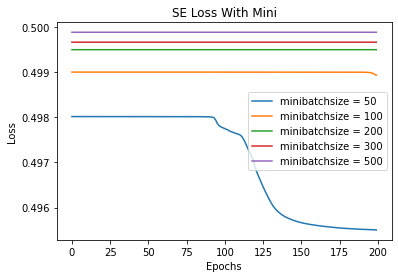

In [ ]:
plt.plot(loss_se_mini_1,label="minibatchsize = 50")
plt.plot(loss_se_mini_2,label="minibatchsize = 100")
plt.plot(loss_se_mini_3,label="minibatchsize = 200")
plt.plot(loss_se_mini_4,label="minibatchsize = 300")
plt.plot(loss_se_mini_5,label="minibatchsize = 500")
plt.title("SE Loss With Mini")
plt.xlabel("Epochs")
plt.ylabel("Loss")  
plt.legend(loc='right')
plt.savefig('3_e_minibatch.png')

**So here also less the size of minibatch for a given no. of epochs learning will be less.**